In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM

F_comp = 80 # flux completeness %
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(7, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

In [2]:
# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN3.csv', index_col='Seq')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN3.csv', index_col='Seq')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN3.csv', index_col='Seq')

# All CIGALE sources
oCDFS = pd.read_csv('../DATA/Ollie Data/CDFS/results.txt', delim_whitespace=True, index_col='id')
oCOSMOS = pd.read_csv('../DATA/Ollie Data/COSMOS/results.txt', delim_whitespace=True, index_col='id')
oUDS = pd.read_csv('../DATA/Ollie Data/UDS/results.txt', delim_whitespace=True, index_col='id')

In [3]:
def mask_data(zfourge, cigale, survey_name):
    # Use Mask
    use_mask = zfourge['Use'] == 1 
    zfourge = zfourge.loc[use_mask]
    cigale = cigale.loc[use_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Use=1: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Use=1: {len(cigale)}')

    # LIR Mask
    lir_mask = zfourge['LIR'] > 0 
    zfourge = zfourge.loc[lir_mask]
    cigale = cigale.loc[lir_mask]
    # print(f'Number of ZFOURGE {survey_name} sources LIR>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources LIR>0: {len(cigale)}')

    # F24 Mask
    F24_mask = zfourge['F24'] > 0 
    zfourge = zfourge.loc[F24_mask]
    cigale = cigale.loc[F24_mask]
    # print(f'Number of ZFOURGE {survey_name} sources F24>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources F24>0: {len(cigale)}')

    # Redshift Mask
    red_mask = (zfourge['zpk'] >= redshift_bins[0][0]) & (zfourge['zpk'] <= redshift_bins[-1][1]) 
    zfourge = zfourge.loc[red_mask]
    cigale = cigale.loc[red_mask]
    # print(f'Number of ZFOURGE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(cigale)}')

    # AGN Mask
    agn_mask = (zfourge['irAGN'] == 1) | (zfourge['radAGN'] == 1) | (zfourge['xAGN'] == 1) 
    zfourge = zfourge.loc[~agn_mask]
    cigale = cigale.loc[~agn_mask]
    # print(f'Number of ZFOURGE {survey_name} sources AGN=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources AGN=0: {len(cigale)}')
    
    # Nan Mask
    nan_mask = ~np.isnan(cigale['bayes.universe.luminosity_distance'])
    zfourge = zfourge.loc[nan_mask]
    cigale = cigale.loc[nan_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Nan=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Nan=0: {len(cigale)}')
    
    # Common sources
    common_sources = zfourge.index.intersection(cigale.index)
    zfourge = zfourge.loc[common_sources]
    cigale = cigale.loc[common_sources]
    print(f'Number of common sources: {len(zfourge)}')
    print('\n')
    return zfourge, cigale

CDFS_m, oCDFS_m = mask_data(CDFS, oCDFS, 'CDFS')
COSMOS_m, oCOSMOS_m = mask_data(COSMOS, oCOSMOS, 'COSMOS')
UDS_m, oUDS_m = mask_data(UDS, oUDS, 'UDS')

# All ZFOURGE sources
df = pd.concat([CDFS_m, COSMOS_m, UDS_m], ignore_index=True)
odf = pd.concat([oCDFS_m, oCOSMOS_m, oUDS_m], ignore_index=True)
print(f'Number of ZFOURGE sources: {len(df)}')
print(f'Number of CIGALE sources: {len(odf)}')

Number of CIGALE CDFS sources Use=1: 13299
Number of CIGALE CDFS sources LIR>0: 8486
Number of CIGALE CDFS sources F24>0: 8486
Number of CIGALE CDFS sources 0.0 <= z <= 6.0: 8469
Number of CIGALE CDFS sources AGN=0: 8193
Number of CIGALE CDFS sources Nan=0: 8187
Number of common sources: 8187


Number of CIGALE COSMOS sources Use=1: 12901
Number of CIGALE COSMOS sources LIR>0: 7954
Number of CIGALE COSMOS sources F24>0: 7954
Number of CIGALE COSMOS sources 0.0 <= z <= 6.0: 7947
Number of CIGALE COSMOS sources AGN=0: 7815
Number of CIGALE COSMOS sources Nan=0: 7815
Number of common sources: 7815


Number of CIGALE UDS sources Use=1: 11447
Number of CIGALE UDS sources LIR>0: 6557
Number of CIGALE UDS sources F24>0: 6557
Number of CIGALE UDS sources 0.0 <= z <= 6.0: 6551
Number of CIGALE UDS sources AGN=0: 6436
Number of CIGALE UDS sources Nan=0: 6436
Number of common sources: 6436


Number of ZFOURGE sources: 22438
Number of CIGALE sources: 22438


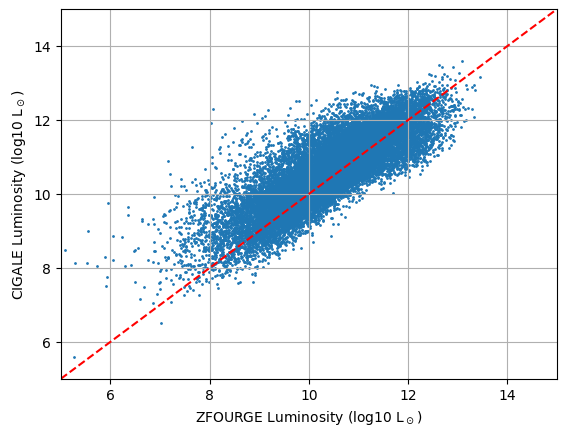

In [4]:
zf_lum = df['LIR'] # Solar Luminosity
cg_lum = (odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])/(3.83*10**26) # Solar Luminosity

x = np.linspace(5, 15, 100)

plt.scatter(np.log10(zf_lum), np.log10(cg_lum), s=1)
plt.plot(x, x, linestyle='--', color='red')
plt.ylabel('CIGALE Luminosity (log10 L$_\odot$)')
plt.xlabel('ZFOURGE Luminosity (log10 L$_\odot$)')
plt.grid()
plt.xlim(5, 15)
plt.ylim(5, 15)
plt.show()

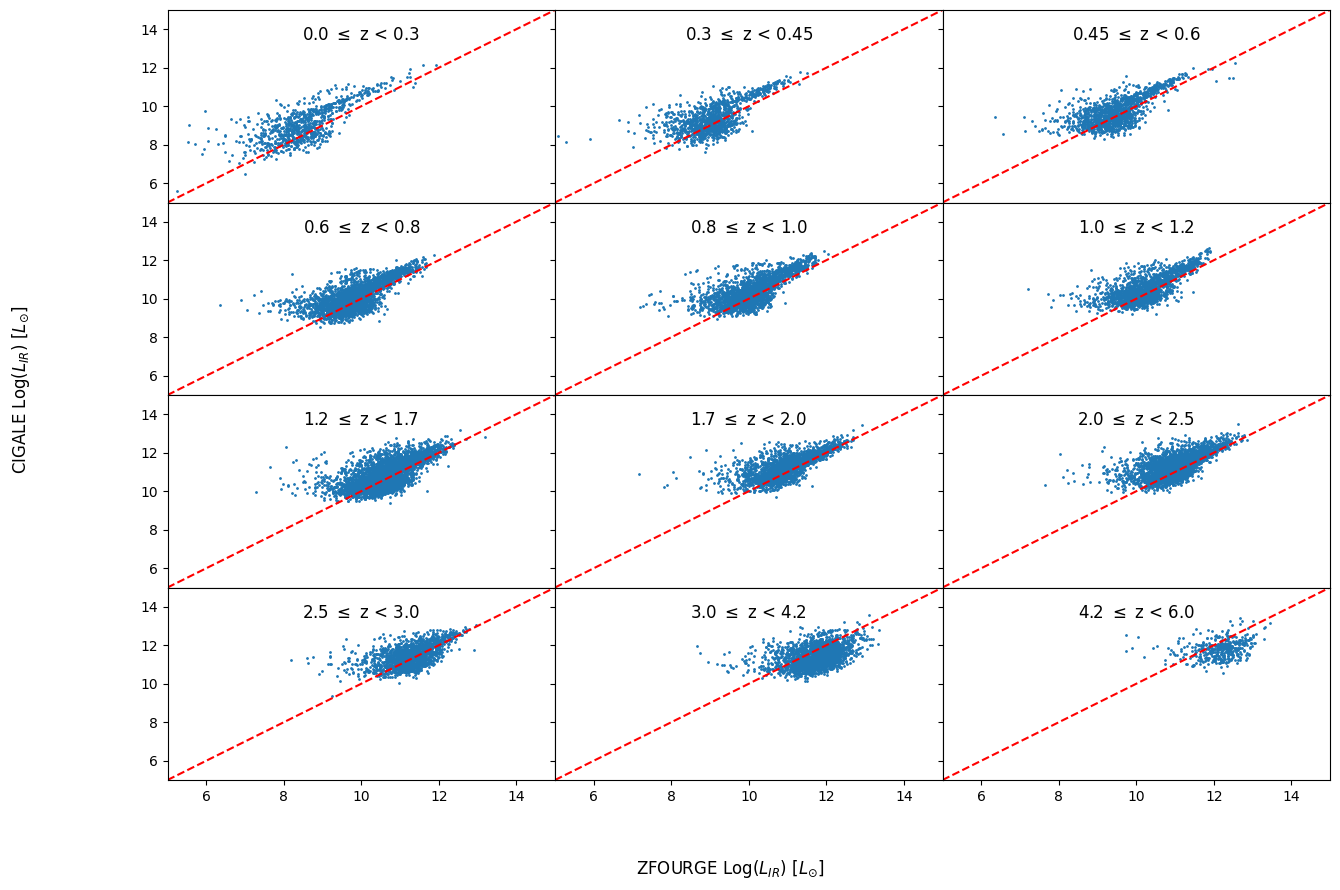

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
x = np.linspace(5, 15, 100)
z = df['zpk'].values.copy() # redshift

for ax, (z_start, z_end) in zip(axes.flatten(), redshift_bins):
    mask_z = (z >= z_start) & (z < z_end)
    ax.set_title(f'{z_start} $\leq$ z < {z_end}', y=0.80, x=0.5)
    ax.scatter(np.log10(zf_lum[mask_z]), np.log10(cg_lum[mask_z]), s=1)
    ax.plot(x, x, linestyle='--', color='red')
    ax.set_xlim(5, 15)
    ax.set_ylim(5, 15)

fig.supxlabel('ZFOURGE Log($L_{IR}$) [$L_{\odot}$]')
fig.supylabel('CIGALE Log($L_{IR}$) [$L_{\odot}$]')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()